For citation information, please see the "Source Information" section listed in the associated README file: https://github.com/stephbuon/digital-history/tree/master/hist3368-week12-word-context-vectors

# Hist 3368 - Week 12: Word Context Vectors with Gensim

## Teaching Version

#### By Jo Guldi

In [17]:
import pandas as pd
import csv
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
import gensim
import multiprocessing
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

In [90]:
def structure_data(sentences, lemma, stopwords, stemmed):

    # tokenize documents with gensim's tokenize() function
    token_list = [list(gensim.utils.tokenize(sent, lower=True)) for sent in sentences]
    
    # build bigram model
    bigram_mdl = gensim.models.phrases.Phrases(token_list, min_count=1, threshold=2)

    # lemmatize the tokens
    if lemma == True:
        pool = multiprocessing.Pool()
        token_list =  pool.map(lemmatize_column, token_list) #[[wn.morphy(item) for item in list] for list in token_list] 
        token_list = [[item for item in list if item is not None] for list in token_list] 
    token_list[0][:15]

    # remove stopwords and/or do stemming
    from gensim.parsing.preprocessing import preprocess_string#, remove_stopwords#, #stem_text
    CUSTOM_FILTERS = []
    if stopwords == True:
        from gensim.parsing.preprocessing import remove_stopwords
        CUSTOM_FILTERS.append(remove_stopwords)
    if stemmed == True:
        from gensim.parsing.preprocessing import stem_text
        CUSTOM_FILTERS.append(stem_text)
        
    processed = [preprocess_string(" ".join(word), CUSTOM_FILTERS) for word in token_list]
    #processed = [[item for item in list if item] for list in processed]

    # apply bigram model to list
    result = [bigram_mdl[item] for item in processed]
    
    return(result)
   

#### Load some Data

In [6]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [7]:
congress = pd.read_csv("congress1967-2010.csv")
all_data = congress[congress['year'] >= 1967]
all_data = congress[congress['year'] <= 1983]
#congress = pd.read_csv("eighties_data.csv")

In [8]:
all_data[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
0,0,0,Those who do not enjoy the privilege of the fl...,1967-01-10,The VICE PRESIDENT,16,1967,1,1967-01-01
1,1,1,Mr. President. on the basis of an agreement re...,1967-01-10,Mr. MANSFIELD,35,1967,1,1967-01-01
2,2,2,The Members of the Senate have heard the remar...,1967-01-10,The VICE PRESIDENT,40,1967,1,1967-01-01
3,3,3,The Chair lays before the Senate the following...,1967-01-10,The VICE PRESIDENT,151,1967,1,1967-01-01
4,4,4,Secretary of State.,1967-01-10,Mrs. AGNES BAGGETT,3,1967,1,1967-01-01


In [9]:
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year', 'speaker','Unnamed: 0', 'Unnamed: 0.1', 'word_count', 'month'], 1)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
all_data['index'] = np.arange(len(all_data)) # create an 'index' column

In [11]:
all_data.head()

,speech,month_year,5yrperiod,index
0,Those who do not enjoy the privilege of the fl...,1967-01-01,1965.0,0
1,Mr. President. on the basis of an agreement re...,1967-01-01,1965.0,1
2,The Members of the Senate have heard the remar...,1967-01-01,1965.0,2
3,The Chair lays before the Senate the following...,1967-01-01,1965.0,3
4,Secretary of State.,1967-01-01,1965.0,4


#### Downsample

In [12]:
sample_l = all_data.sample(500000)
sample_m = sample_l.sample(50000)
sample = sample_m.sample(5000)

## Introducing Gensim, a Tool for Studying Word Embeddings

In [ ]:
sentences = structure_data(all_data['speech'], lemma = False, stopwords = True, stemmed = True) # <---- switch out sample_l to all_data, sample_s or sample_m here

In [ ]:
sentences[:5]

In [ ]:
congress_model = gensim.models.Word2Vec(
    sentences = sentences,
    #workers= 29, # if you have more computing power available
    min_count = 2, # remove words stated only once
    size = 100) # size of neuralnet layers; default is 100; higher for larger corpora

In [92]:
#congress_model.save('congress_model')

In [93]:
#congress_model = gensim.models.Word2Vec.load('congress_model') 

#### Find the CONTEXT for One Word

In [94]:
man_vector = congress_model.wv['man']
congress_model.wv.similar_by_vector(man_vector)

[('man', 1.0),
 ('great', 0.9939815998077393),
 ('anniversari', 0.9921808838844299),
 ('die', 0.9919556379318237),
 ('fight', 0.9918848872184753),
 ('citi', 0.9916784167289734),
 ('san_francisco', 0.991585910320282),
 ('miami', 0.9914738535881042),
 ('brave', 0.9907348155975342),
 ('compass', 0.9907312989234924)]

In [95]:
woman_vector = congress_model.wv['woman']
congress_model.wv.similar_by_vector(woman_vector)

[('woman', 1.0),
 ('disadvantag', 0.9986030459403992),
 ('watch', 0.9985404014587402),
 ('station', 0.9984335899353027),
 ('germani', 0.9983009099960327),
 ('republ', 0.9982349872589111),
 ('belief', 0.9982324838638306),
 ('lead', 0.9982187747955322),
 ('japan', 0.998198390007019),
 ('frustrat', 0.9981683492660522)]

In [96]:
individual_vector = congress_model.wv['individual']
congress_model.wv.similar_by_vector(individual_vector)

KeyError: "word 'individual' not in vocabulary"

In [97]:
soldier_vector = congress_model.wv['soldier']
congress_model.wv.similar_by_vector(soldier_vector)

[('soldier', 0.9999999403953552),
 ('near', 0.9992608428001404),
 ('west', 0.9992541074752808),
 ('typic', 0.9991981983184814),
 ('lead', 0.9991543292999268),
 ('instrument', 0.9991330504417419),
 ('graduat', 0.9991236925125122),
 ('quarter', 0.9990744590759277),
 ('occup', 0.9990739822387695),
 ('overcom', 0.9990684986114502)]

## Subtracting Vectors

In [98]:
diff = congress_model.wv['man'] - congress_model.wv['woman']
congress_model.wv.similar_by_vector(diff)

[('man', 0.9978268146514893),
 ('great', 0.9928092956542969),
 ('plain', 0.9868414402008057),
 ('die', 0.9860683083534241),
 ('san_francisco', 0.9855151176452637),
 ('associ', 0.9854938983917236),
 ('anniversari', 0.9853604435920715),
 ('miami', 0.9848278760910034),
 ('tire', 0.9846345782279968),
 ('homemad', 0.9843970537185669)]

In [99]:
diff = congress_model.wv['woman'] - congress_model.wv['boy']
congress_model.wv.similar_by_vector(diff)

KeyError: "word 'boy' not in vocabulary"

### Distance and Similarity with Vectors in GENSIM

With similarity, the higher the number, the more alike two terms are in the context in which they are used. 

In [100]:
congress_model.wv.similarity('women', 'men')

0.9960769

In [101]:
congress_model.wv.similarity('soldier', 'men')

0.997764

In [102]:
congress_model.wv.similarity('women', 'individual')

KeyError: "word 'individual' not in vocabulary"

#### Find the words most SIMILAR to each word

In [103]:
congress_model.wv.most_similar("women", topn = 20)

[('defend', 0.9990057945251465),
 ('pictur', 0.9989752769470215),
 ('south_vietnam', 0.9989703893661499),
 ('won', 0.9988438487052917),
 ('fear', 0.9987069368362427),
 ('battl', 0.9987041354179382),
 ('nativ', 0.9986868500709534),
 ('cuba', 0.9986411929130554),
 ('negoti', 0.9985318183898926),
 ('new_england', 0.9984727501869202),
 ('human', 0.9983671307563782),
 ('reli', 0.99836665391922),
 ('fortun', 0.9983601570129395),
 ('burn', 0.998332142829895),
 ('prove', 0.9983017444610596),
 ('unfortun', 0.9982720613479614),
 ('tour', 0.998260498046875),
 ('seven', 0.9982436895370483),
 ('flower', 0.9982373714447021),
 ('dougla', 0.9982167482376099)]

In [104]:
congress_model.wv.most_similar("soldier", topn = 20)

[('near', 0.9992608428001404),
 ('west', 0.9992541074752808),
 ('typic', 0.9991981983184814),
 ('lead', 0.9991543292999268),
 ('instrument', 0.9991329908370972),
 ('graduat', 0.9991236925125122),
 ('quarter', 0.999074399471283),
 ('occup', 0.99907386302948),
 ('overcom', 0.9990684986114502),
 ('depress', 0.9990139603614807),
 ('constant', 0.9989932179450989),
 ('threat', 0.9989822506904602),
 ('detroit', 0.9989442825317383),
 ('wors', 0.9989230632781982),
 ('island', 0.9989188313484192),
 ('democraci', 0.9989145994186401),
 ('attack', 0.9989122152328491),
 ('deploy', 0.9989041686058044),
 ('agent', 0.9988955855369568),
 ('mass', 0.9988906383514404)]

#### Interpreting vector similarity

Try your own hand at interpreting these outputs. 

In [105]:
congress_model.wv.most_similar("iraq", topn = 10)

KeyError: "word 'iraq' not in vocabulary"

How do you interpret these similarities?

In [106]:
congress_model.wv.most_similar("britain", topn = 10)

[('feet', 0.9987874031066895),
 ('sing', 0.998785674571991),
 ('waterwai', 0.9987305402755737),
 ('gone', 0.9987099170684814),
 ('prevail', 0.9986897706985474),
 ('warfar', 0.9986738562583923),
 ('worst', 0.9986512660980225),
 ('credit_card', 0.9985557198524475),
 ('chesapeak', 0.9985406398773193),
 ('longer', 0.9985253810882568)]

#### Visualize the similarities as a Dendrogram

In [107]:
keywords = ['dream', 'bombing', 'warfare', 'prosperity', 'wealth', 'happiness', 'today', 'tomorrow', 'past', 'present', 'future', 'america', 'france', 'britain', 'china', 'democratic', 'democracy', 'welfare', 'communism', 'russia', 'congress', 'debate', 'hearing', 'protest']

In [108]:
keyword_vectors = congress_model.wv[keywords]

KeyError: "word 'bombing' not in vocabulary"

In [109]:
from scipy.cluster.hierarchy import dendrogram, linkage
links = linkage(keyword_vectors, method='complete', metric='seuclidean')

NameError: name 'keyword_vectors' is not defined

In [110]:
from matplotlib import pyplot as plt

l = links

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=16,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(keywords[v])
)
plt.show()


NameError: name 'links' is not defined

*Note: if you get an error above, delete any words from the list.*

### Visualizing Abstract Relatedness

In [116]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

In [117]:
#%matplotlib inline

def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

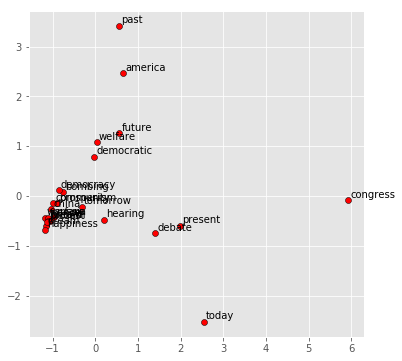

In [118]:
display_pca_scatterplot(congress_model.wv, keywords)

## Comparing the Context of One Keyword Over Time with GENSIM

#### Make a word embedding model per period

In [119]:
dataname = 'sample-m'

In [120]:
cd '/scratch/group/history/hist_3368-jguldi/congress-embeddings'

/scratch/group/history/hist_3368-jguldi/congress-embeddings


In [121]:
for period1 in periodnames:
    print('working on ', period1)

    period_data = sample_m[sample_m['5yrperiod'] == period1] # select one period at a time
    print('mining ', period1)
    sentences = sentences_m # if you don't already have this, the code to make it is: make_sentences(sample_m['speech']).copy() # break data into sentences for that period only 
    ####### tweak here after the first run to use the old data without generating it again
    period_model = gensim.models.Word2Vec( # make a gensim model for that data
        sentences = sentences,
        min_count = 2, 
        size = 100)  
    period_model.save(dataname + '-model-' + str(period1)) # save the model with the name of the period
    #period_model = gensim.models.Word2Vec.load(dataname + '-model-' + str(period1)) # to load a saved model


working on  1970.0
mining  1970.0


KeyboardInterrupt: 

#### Search each 5-year model for a keyword.

In [122]:
keyword1 = 'black'

In [123]:
#########  after the first run, use this line to call the old data without generating it again
keyword_context = []
dates_found = []

for p in range(len(periodnames)) :

    period1 = periodnames[p]
    print('working on ', period1)
    period_model = gensim.models.Word2Vec.load(dataname + '-model-' + str(period1)) # to load a saved model

    ## analysis
    if keyword1 in period_model.wv.vocab:
        print('found ', keyword1)
        
        keyword_vector = congress_model.wv[keyword1]
        keyword_context_period = period_model.wv.similar_by_vector(keyword_vector, topn = 5000) # extract the context of how women were talked about in that period

        #keyword_context_period = period_model.wv.most_similar(keyword1, topn = 5000) # extract the context of how women were talked about in that period
        keyword_context.append(keyword_context_period) # save the context of how women were talked about for later
        dates_found.append(period1)

working on  1970.0
found  black
working on  1975.0
found  black
working on  1980.0
found  black
working on  1965.0
found  black


#### Visualize it

In [127]:
# helper function to abstract only unique values while keeping the list in the same order -- the order of first appearance
def unique2(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [128]:
all_words = []
for i in range(len(dates_found)):
    words = [item[0] for item in keyword_context[i]][:10]
    all_words.append(words)

all_words2 = []
for list in all_words:
    for word in list:
        all_words2.append(word)

numwords = 10


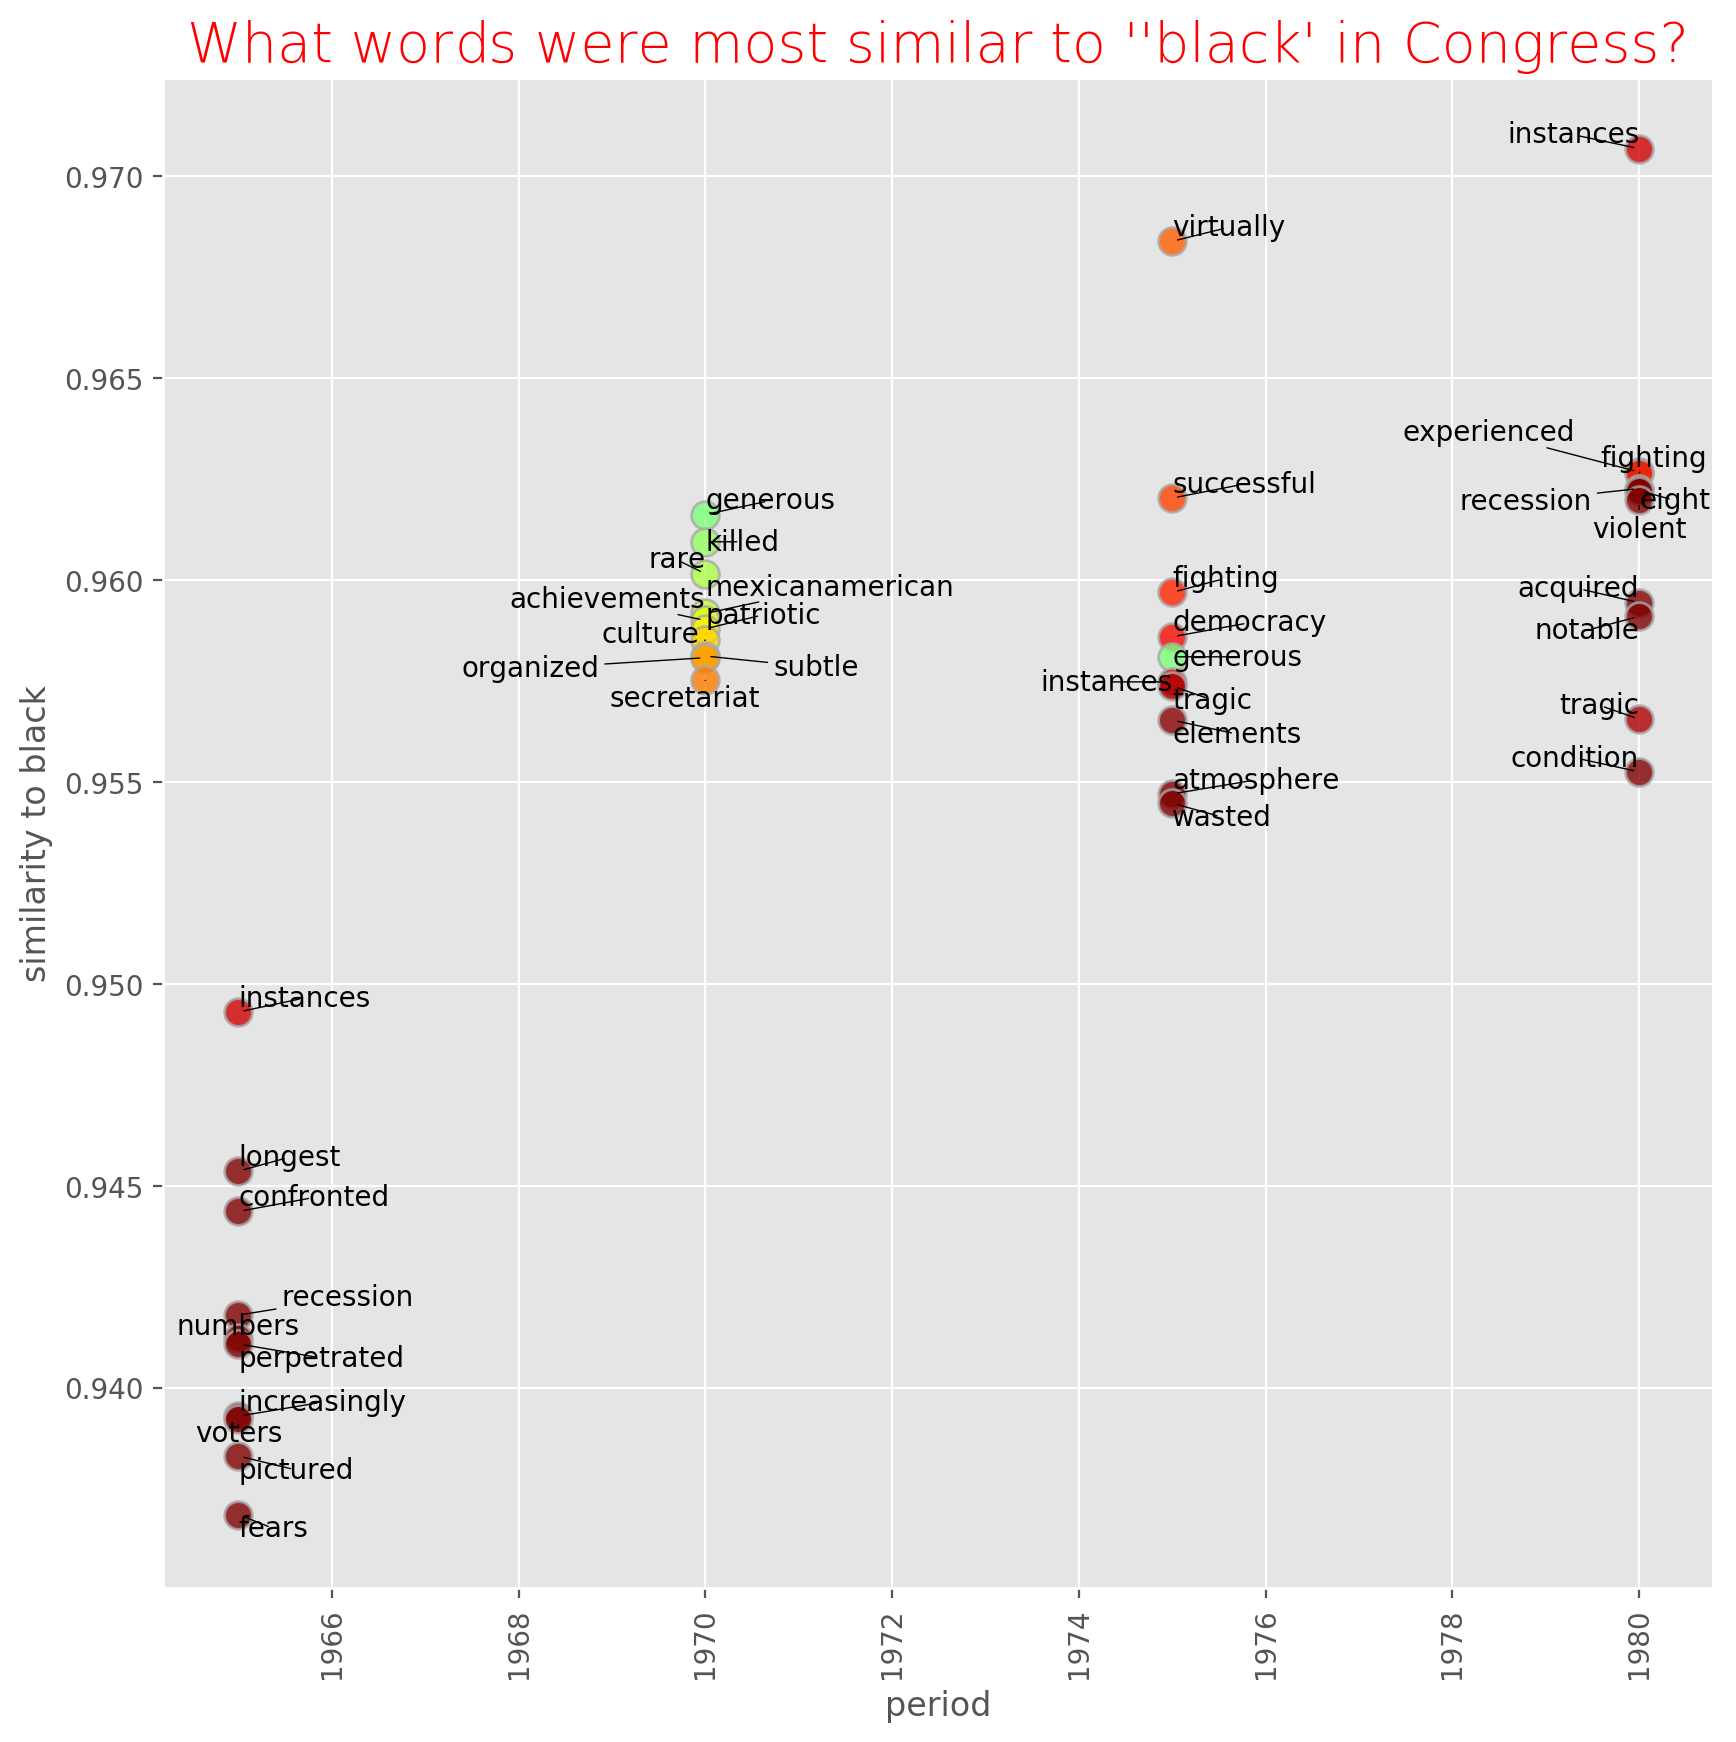

In [129]:
%matplotlib inline
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from adjustText import adjust_text

# change the figure's size here
plt.figure(figsize=(10,10), dpi = 200)

texts = []

# plt.annotate only plots one label per iteration, so we have to use a for loop 
for i in range(len(dates_found)):    # cycle through the period names
    
    #yyy = int(keyword_per_year[keyword_per_year['5yrperiod'] == int(xx)]['count'])   # how many times was the keyword used that year?
                     
    for j in range(10):     # cycle through the first ten words (you can change this variable)
        
        xx = dates_found[i]        # on the x axis, plot the period name
        yy = [item[1] for item in keyword_context[i]][j]         # on the y axis, plot the distance -- how closely the word is related to the keyword
        txt = [item[0] for item in keyword_context[i]][j]        # grab the name of each collocated word
        colorindex = unique2(all_words2).index(txt)   # this command keeps all dots for the same word the same color
        
        plt.scatter(                                             # plot dots
            xx, #x axis
            yy, # y axis
            linewidth=1, 
            color = colors[colorindex],
            edgecolors = 'darkgray',
            s = 100, # dot size
            alpha=0.8)  # dot transparency

        # make a label for each word
        texts.append(plt.text(xx, yy, txt))

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=.7, 
                    expand_points=(1, 1), expand_text=(1, 1),
                    arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xticks(rotation=90)

# Add titles
plt.title("What words were most similar to ''" + keyword1 + "' in Congress?", fontsize=20, fontweight=0, color='Red')
plt.xlabel("period")
plt.ylabel("similarity to " + keyword1)


filename = 'words-similar-to-' + keyword1 + '-' + dataname
plt.savefig(filename)